## Detection of DNA-seqFISH spots

Here, we determine the spots for DNA-seqFISH. 

In [1]:
import os
import pandas as pd
import numpy as np
import bigfish
import bigfish.stack as stack
import bigfish.detection as detection
import bigfish.multistack as multistack
import bigfish.plot as plot
from skimage import data
import napari
import scipy.spatial as ss  
from scipy.spatial import distance
import datetime
from matplotlib import pyplot as plt
import seaborn as sns

# Get the path of the current directory.
current_directory = os.getcwd()

# Get the path two levels up from the current directory.
dir = os.path.dirname(current_directory)


for Pos in range(1, 4):  # oop through numbers 1 to 3. Changes may be needed if necessary.
    Pos_padded = str(Pos).zfill(2)

    # Assemble the path to the directory.
    directory_path = os.path.join(dir, "1_processed_images", "5_DNA-seqFISH_spot_determination", "Pos" + Pos_padded, "candidate")

    # Create the directory.
    os.makedirs(directory_path, exist_ok=True)


def spot_detect_for_check(Pos_no, file_name):                
    path_input = os.path.join(dir, "1_processed_images", "3_diveded_files")

    path = os.path.join(path_input, Pos_no, file_name)
    # Select the FISH image.
    dna  = stack.read_image(path)

    # Generate MIP (Maximum Intensity Projection) images for image display
    dna_mip = stack.maximum_projection(dna)

    # Nucleus image
    path = os.path.join(dir, "1_processed_images", "3_diveded_files", 
                        Pos_no, "ND53_C4_TyD.tif")
    nuc  = stack.read_image(path)
    nuc_mip = stack.maximum_projection(nuc)


    # Spot detection
    # Perform filtering, detection of local maxima, detection of the optimal threshold, and detection of bright spots based on the threshold all at once.

    spots, threshold = detection.detect_spots(
                        images=dna, 
                        return_threshold=True, 
                        voxel_size=(130, 130, 130),
                        spot_radius=(240, 189, 189))

    print("Threshold : ", threshold)
    plot.plot_detection(dna_mip, spots, contrast=True)
    return threshold


def spot_detect(Pos_no, file_name, threshold):                
    path_input = os.path.join(dir,"1_processed_images", "3_diveded_files")

    path = os.path.join(path_input, Pos_no, file_name)
    # Select the FISH image.
    dna  = stack.read_image(path)

    # Generate MIP (Maximum Intensity Projection) images for image display
    dna_mip = stack.maximum_projection(dna)

    # DNA-seqFISH MIP image.
    path = os.path.join(dir,"1_processed_images", "4_segmentation", 
                        Pos_no, "DNAseqFIS_foci_enhance_stack.tif")
    DNA_seqFISH  = stack.read_image(path)

    # Nucleus segmentation image.
    path = os.path.join(dir,"1_processed_images", "4_segmentation", 
                        Pos_no, "02_nuc_seg_human_corrected.tif")
    nuc_seg  = stack.read_image(path)
    nuc_seg = nuc_seg.astype('uint16')

    # Exclude nuclei touching the XY axis here.
    # Extract cell IDs where the cytoplasm touches the image edges.
    cells_cropped = np.unique(nuc_seg[0]).tolist()
    cells_cropped = cells_cropped + np.unique(nuc_seg[-1]).tolist()
    cells_cropped = cells_cropped + np.unique(nuc_seg[:,0]).tolist()
    cells_cropped = cells_cropped + np.unique(nuc_seg[:,-1]).tolist()
    cells_cropped = list(set(cells_cropped)) 
    cells_cropped.remove(0)
    # print("Cropped cells are : ", cells_cropped)

    for i in cells_cropped:
        nuc_seg = np.where(nuc_seg == i, 0, nuc_seg)

    # Create a mask.
    nuc_seg_mask = np.where(nuc_seg > 0, 1, 0)
    dna_masked = dna * nuc_seg_mask
    dna_masked = dna_masked.astype('uint16')
    dna_masked_mip = stack.maximum_projection(dna_masked)

    # Nucleus image
    path = os.path.join(dir,"1_processed_images", "3_diveded_files", 
                        Pos_no, "ND53_C4_TyD.tif")
    nuc  = stack.read_image(path)
    nuc_mip = stack.maximum_projection(nuc)



    # Spot detection
    # Perform filtering, detection of local maxima, detection of the optimal threshold, and detection of bright spots based on the threshold all at once.

    spots = detection.detect_spots(
        images=dna_masked, 
        threshold = threshold,
        return_threshold=False, 
        voxel_size=(130, 130, 130),  # In nanometer (one value per dimension zyx).
        spot_radius=(240, 189, 189))  
    plot.plot_detection(dna_masked_mip, spots, contrast=True)
    
    
# Function to retrieve the spot image for the corresponding ND, Col, and display it in napari.
def napari_check(ND,Col,Pos_no):
    file_name = 'ND'+str(ND)+'_C'+str(Col)+'_TyD.tif'

    path_input = os.path.join(dir, "1_processed_images", "3_diveded_files")

    path = os.path.join(path_input, Pos_no, file_name)
    # Select the FISH image.
    dna  = stack.read_image(path)

    # Generate MIP (Maximum Intensity Projection) images for image display
    dna_mip = stack.maximum_projection(dna)

    
    # fiducial marker enhanced image
    path = os.path.join(dir, "1_processed_images", "4_segmentation", 
                    Pos_no, "Fiducial_enhance_stack.tif")
    fiducial  = stack.read_image(path)
    
    # DNA-seqFISH MIP image
    path = os.path.join(dir, "1_processed_images","4_segmentation", 
                        Pos_no, "DNAseqFIS_foci_enhance_stack.tif")
    DNA_seqFISH  = stack.read_image(path)

    # Nucleus segmentation image
    path = os.path.join(dir, "1_processed_images","4_segmentation", 
                        Pos_no, "02_nuc_seg_human_corrected.tif")
    nuc_seg  = stack.read_image(path)
    nuc_seg = nuc_seg.astype('uint16')

    nuc_seg_mask = np.where(nuc_seg > 0, 1, 0)

    dna_masked = dna * nuc_seg_mask
    dna_masked = dna_masked.astype('uint16')

    dna_masked_mip = stack.maximum_projection(dna_masked)

    # Nucleus image
    path = os.path.join(dir, "1_processed_images","3_diveded_files", 
                        Pos_no, "ND53_C4_TyD.tif")
    nuc  = stack.read_image(path)
    nuc_mip = stack.maximum_projection(nuc)


    # Here, read the file containing various information.
    ref_a = os.path.join(dir, "X1_accessory_data","DNA-RNA-seqFISH-probe-summary.csv")
    ref_data = pd.read_csv(ref_a, index_col=0)
    stack_id = 'ND'+str(ND)+'_C'+str(Col)+'_TyD'
    ref_data_res = ref_data[ref_data['Stack_ID'] == stack_id]

    path = os.path.join(dir, "1_processed_images", "5_DNA-seqFISH_spot_determination", 
                                    Pos_no, "candidate",ref_data_res['Locus_ID'][0]+"__spots.csv")
    df_concat_Nanog = pd.read_csv(path, index_col=0)
    spots_detected = df_concat_Nanog[['Z_pix', 'Y_pix', 'X_pix']].to_numpy()

    # Check with napari and correct as needed.
    # Here, decide not to forcefully assign those where the fiducial and chromosome 6 are close.

    viewer = napari.view_image(fiducial, name='fiducial',
                colormap = 'red', gamma = 0.52,
                          contrast_limits = [250, 2000])
    viewer.add_image(DNA_seqFISH, name='DNA_seqFISH',
                               opacity = 0.25, colormap = 'blue',
                               contrast_limits = [400, 3000], blending='additive')
    viewer.add_image(nuc, name='nuc', opacity = 0.15, blending='additive',
                              contrast_limits = [1000, 20000])
    viewer.add_labels(nuc_seg, opacity = 0.15,blending='additive')
    viewer.add_image(dna, colormap = 'green',
                     opacity = 0.2, blending='additive', gamma = 2.0,
                    contrast_limits = [200, 1600])

    viewer.add_points(spots_detected, size=15, 
                      edge_width=0.2, 
                      symbol = "ring",
                      edge_color = 'red', 
                      face_color = 'red', 
                      n_dimensional = True, blending='additive', name='spots_detected')
    
    return viewer



def napari_check2(fov):
    # fiducial marker enhanced image
    path = os.path.join(dir, "1_processed_images", "4_segmentation", 
                    'Pos'+str(fov).zfill(2), "Fiducial_enhance_stack.tif")
    fiducial  = stack.read_image(path)
    
    # DNA-seqFISH MIP image
    path = os.path.join(dir, "1_processed_images", "4_segmentation", 
                        'Pos'+str(fov).zfill(2), "DNAseqFIS_foci_enhance_stack.tif")
    DNA_seqFISH  = stack.read_image(path)

    # Nucleus segmentation image
    path = os.path.join(dir, "1_processed_images", "4_segmentation", 
                        'Pos'+str(fov).zfill(2), "02_nuc_seg_human_corrected.tif")
    nuc_seg  = stack.read_image(path)
    nuc_seg = nuc_seg.astype('uint16')

    # Nucleus image
    path = os.path.join(dir, "1_processed_images", "3_diveded_files", 
                        'Pos'+str(fov).zfill(2), "ND53_C4_TyD.tif")
    nuc  = stack.read_image(path)
    nuc_mip = stack.maximum_projection(nuc)

    # ここで、特定のfovの座標を取り出す。
    spots_detected = summary_data_fid6.loc[summary_data_fid6['fov']==fov,['z','y','x']].to_numpy()

    # napariでチェックし、適宜修正する。
    # ここで、fiducialと6番染色体が近いものは無理にアサインしないことにする。

    from skimage import data
    import napari

    viewer = napari.view_image(fiducial, name='fiducial',
                colormap = 'red', gamma = 0.52,
                          contrast_limits = [250, 2000])
    viewer.add_image(DNA_seqFISH, name='DNA_seqFISH',
                               opacity = 0.25, colormap = 'blue',
                               contrast_limits = [400, 3000], blending='additive')
    viewer.add_image(nuc, name='nuc', opacity = 0.15, blending='additive',
                              contrast_limits = [1000, 20000])
    viewer.add_labels(nuc_seg, opacity = 0.15,blending='additive')

    viewer.add_points(spots_detected, size=15, 
                      edge_width=0.2, 
                      symbol = "ring",
                      edge_color = 'red', 
                      face_color = 'red', 
                      n_dimensional = True, blending='additive', name='spots_detected', 
                      opacity = 0.15)
    return viewer


def get_spot_from_napari(fov, df):
    spots_corr = viewer.layers['spots_detected'].data
    b = df.loc[df['fov']!=fov,:].copy()
    a_0 = pd.DataFrame()
    for i in range(len(spots_corr)):
        a = df.loc[(df['fov']==fov)&(df['z']==spots_corr[i][0])&
                  (df['y']==spots_corr[i][1])&
                  (df['x']==spots_corr[i][2]),
                             :].copy()
        a_0 = pd.concat([a_0,a])
        
    c = pd.concat([a_0,b])
    return c

## Spot detection
First and foremost, determine the threshold for spot detection for all DNA-seqFISH images in advance. By specifying a particular field of view beforehand and executing the cell below, spot detection within each field of view is performed based on the threshold deemed optimal by Big-FISH. The signal-to-noise ratio differs depending on the probe, and in some cases, spots other than the true spots are selected due to the probe. Therefore, the threshold displayed here should be considered as a reference.

In [ ]:
Pos = 1 # Specify the field of view number. In the test data, the field of view numbers range from 1 to 3.


Pos_no = "Pos" + f"{Pos:02d}"
name_list = [f"ND{str(i).zfill(2)}_C{j}_TyD" for i in range(33, 73) for j in range(1, 4)]
threshold_list = []

for i in name_list :
    print(i)
    file_name = i +'.tif'
    threshold = spot_detect_for_check(Pos_no, file_name)
    threshold_list.append(threshold)

Set the threshold below and verify whether the set threshold is appropriate. For test data, the determined thresholds are included in the Threshold column of the X1_accessory_data/DNA-RNA-seqFISH-probe-summary.csv. If you wish to reset the threshold yourself, edit this CSV file.

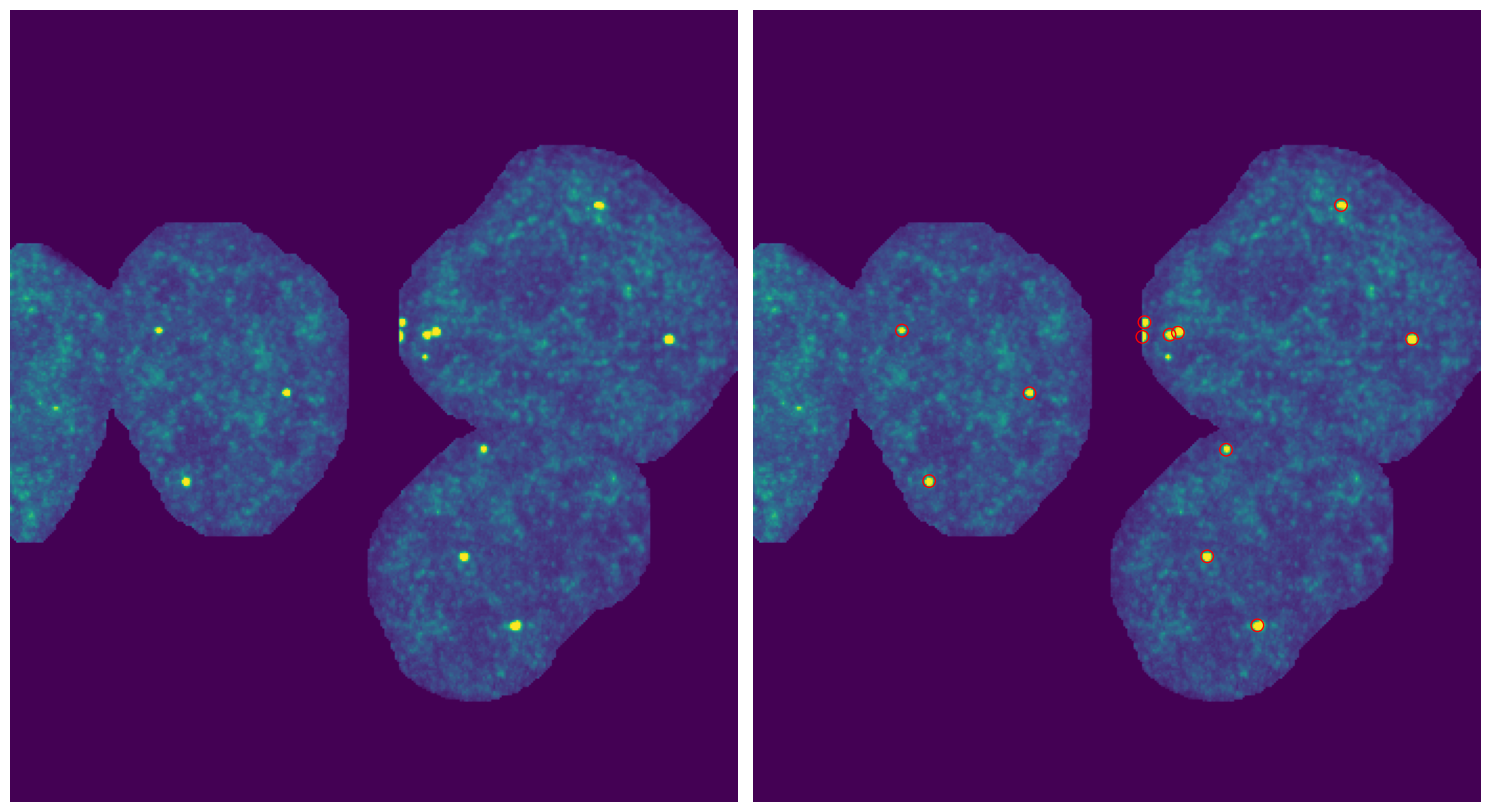

In [2]:
Pos = 1 # Specify the field of view number. In the test data, the field of view numbers range from 1 to 3.
cycle = 45 # In the test data, cycles 33 to 72 correspond to DNA-seqFISH data.
channel = 3 # In the test data, DNA-seqFISH data is acquired in 3 channels.
threshold = 200 # Set the threshold.

file_name = "ND" + str(cycle) + "_C" + str(channel) + "_TyD.tif"
Pos_no = "Pos" + f"{Pos:02d}"
spot_detect(Pos_no, file_name, threshold)

Based on the threshold determined above, detect spots.

In [71]:
# Read the file containing various information.
dir_a = os.path.join(dir, "X1_accessory_data", "DNA-RNA-seqFISH-probe-summary.csv")
ref_data = pd.read_csv(dir_a, index_col=0)


# Specify the range for Pos_no.
Pos_no_range = ['Pos01', 'Pos02', 'Pos03']


for Pos_no in Pos_no_range:
    # This time, cycles 33 to 72 correspond to DNA-seqFISH.
    for ND in range(33,73):
        for Col in range(1,4):
            file_name = 'ND'+str(ND)+'_C'+str(Col)+'_TyD.tif'

            path_input = os.path.join(dir, "1_processed_images", "3_diveded_files")

            path = os.path.join(path_input, Pos_no, file_name)
            # Select the FISH image.
            dna  = stack.read_image(path)

            # Generate MIP (Maximum Intensity Projection) images for image display:
            dna_mip = stack.maximum_projection(dna)

            # DNA-seqFISH MIP image
            path = os.path.join(dir,"1_processed_images","4_segmentation", 
                                Pos_no, "DNAseqFIS_foci_enhance_stack.tif")
            DNA_seqFISH  = stack.read_image(path)

            # Nucleus segmentation image
            path = os.path.join(dir,"1_processed_images","4_segmentation", 
                                Pos_no, "02_nuc_seg_human_corrected.tif")
            nuc_seg  = stack.read_image(path)
            nuc_seg = nuc_seg.astype('uint16')

            # Here, exclude nuclei touching the image edges
            # Extract cell IDs where the nucleus touches the image edges
            cells_cropped = np.unique(nuc_seg[:,0,:]).tolist()
            cells_cropped = cells_cropped + np.unique(nuc_seg[:,-1,:]).tolist()
            cells_cropped = cells_cropped + np.unique(nuc_seg[:,:,0]).tolist()
            cells_cropped = cells_cropped + np.unique(nuc_seg[:,:,-1]).tolist()
            cells_cropped = list(set(cells_cropped)) 
            cells_cropped.remove(0)
            # print("Cropped cells are : ", cells_cropped)


            for i in cells_cropped:
                nuc_seg = np.where(nuc_seg == i, 0, nuc_seg)


            # Create a mask.
            nuc_seg_mask = np.where(nuc_seg > 0, 1, 0)
            dna_masked = dna * nuc_seg_mask
            dna_masked = dna_masked.astype('uint16')
            dna_masked_mip = stack.maximum_projection(dna_masked)

            # Nucleus image
            path = os.path.join(dir,"1_processed_images","3_diveded_files", 
                                Pos_no, "ND53_C4_TyD.tif")
            nuc  = stack.read_image(path)
            nuc_mip = stack.maximum_projection(nuc)


            # Spot detection
            # Perform filtering, detection of local maxima, detection of the optimal threshold, and detection of bright spots based on the threshold all at once.
            # Use the previously set numerical value as the threshold.

            stack_id = 'ND'+str(ND)+'_C'+str(Col)+'_TyD'
            ref_data_res = ref_data[ref_data['Stack_ID'] == stack_id]
            threshold = ref_data_res['Threshold'][0].astype('int').item()

            spots = detection.detect_spots(
                images=dna_masked, 
                threshold = threshold,
                return_threshold=False, 
                voxel_size=(130, 130, 130),  # in nanometer (one value per dimension zyx)
                spot_radius=(240, 189, 189))  
            
            if spots.shape[0] > 0:
                # subpixel fitting
                Spots_sub = bigfish.detection.fit_subpixel(dna, spots.astype('int64'),
                                                        voxel_size = (130, 130, 130),
                                                        spot_radius=(240, 189, 189))

                # Here, narrow down to the top 10 spot intensities within each cell.
                data_df_spots = pd.DataFrame(data=Spots_sub, 
                                    index=range(1,len(Spots_sub)+1),
                                    columns=["Z_pix", "Y_pix", "X_pix"])

                # Assign to the corresponding cell
                coords_int = np.round(Spots_sub).astype(int)  # or np.floor, depends
                coords_int_t = coords_int.T
                coords_int_t[0] = np.where(coords_int_t[0] > nuc.shape[0]-1, nuc.shape[0]-1, coords_int_t[0])
                coords_int_t[0] = np.where(coords_int_t[0] < 0, 0, coords_int_t[0])
                coords_int_t[1] = np.where(coords_int_t[1] > nuc.shape[1]-1, nuc.shape[1]-1, coords_int_t[1])
                coords_int_t[1] = np.where(coords_int_t[1] < 0, 0, coords_int_t[1])
                coords_int_t[2] = np.where(coords_int_t[2] > nuc.shape[2]-1, nuc.shape[2]-1, coords_int_t[2])
                coords_int_t[2] = np.where(coords_int_t[2] < 0, 0, coords_int_t[2])
                coords_int = coords_int_t.T
                values_at_coords = nuc_seg[tuple(coords_int.T)]

                # Insert Cell ID into Pandas data
                data_df_spots['Cell_ID'] = values_at_coords

                # Exclude items where Cell ID is 0.
                data_df_spots = data_df_spots[data_df_spots['Cell_ID'] != 0]
                data_df_spots2 = data_df_spots
                stack_id = 'ND'+str(ND)+'_C'+str(Col)+'_TyD'
                ref_data_res = ref_data[ref_data['Stack_ID'] == stack_id]
                data_df_spots2['Pos_ID'] = Pos_no
                data_df_spots2['geneID'] = ref_data_res['geneID'][0]
                data_df_spots2['Locus_ID'] = ref_data_res['Locus_ID'][0]
                data_df_spots2['Stack_ID'] = stack_id
                data_df_spots2['Probe_position_Start_mm10'] = ref_data_res['Probe_position_Start_mm10'][0].astype('int')
                data_df_spots2['Probe_position_End_mm10'] = ref_data_res['Probe_position_End_mm10'][0].astype('int')


                # Write out the file.
                path_output = os.path.join(dir, "1_processed_images", "5_DNA-seqFISH_spot_determination")
                file_name = ref_data_res['Locus_ID'][0] + '__spots.csv'
                path = os.path.join(path_output, Pos_no, 'candidate', file_name)
                data_df_spots2.to_csv(path)
            
            else : 
                data_df_spots2 = pd.DataFrame(index=[], columns=['Z_pix', 'Y_pix', 'X_pix', 'Cell_ID', 'Pos_ID', 
                                            'geneID', 'Locus_ID', 'Stack_ID', 'Probe_position_Start_mm10', 
                                            'Probe_position_End_mm10'])
                path_output = os.path.join(dir, "1_processed_images", "5_DNA-seqFISH_spot_determination")
                file_name = ref_data_res['Locus_ID'][0] + '__spots.csv'
                path = os.path.join(path_output, Pos_no, 'candidate', file_name)
                data_df_spots2.to_csv(path)

## Verification of Selected Spots
By specifying the cycle and channel and executing the cell below, you can verify the selected spots on napari.

In [72]:
Pos = 1 # Specify the field of view number. In the test data, the field of view numbers range from 1 to 3.
cycle = 45 # In the test data, cycles 33 to 72 correspond to DNA-seqFISH data.
channel = 3 # In the test data, DNA-seqFISH data is acquired in 3 channels.

Pos_no = "Pos" + f"{Pos:02d}"
viewer = napari_check(cycle,channel,Pos_no)

## Determining the Fiducial Markers
Below, select the spots considered to be fiducial markers.
First, identify potential fiducial marker positions based on the averaged image of the DNA-seqFISH. Then, within the same channel, anything within a 3-pixel distance from the candidate fiducial marker positions is considered a fiducial marker.

In [73]:
summary_data = pd.DataFrame()

for i in range(1,4):
    Pos_no = 'Pos' + str(i).zfill(2)

    for ND in range(33,73):
        for Col in range(1,4):
            
            # Here, read out the file with various information.
            dir_a = os.path.join(dir, "X1_accessory_data", "DNA-RNA-seqFISH-probe-summary.csv")
            ref_data = pd.read_csv(dir_a, index_col=0)

            stack_id = 'ND'+str(ND)+'_C'+str(Col)+'_TyD'

            ref_data_res = ref_data[ref_data['Stack_ID'] == stack_id]

            path_input = os.path.join(dir, "1_processed_images", "5_DNA-seqFISH_spot_determination")
            file_name = ref_data_res['Locus_ID'][0] + '__spots.csv'
            path = os.path.join(path_input, Pos_no, 'candidate', file_name)
            df_1 = pd.read_csv(path)
            df_1['Channel'] = Col
            df_1['ND_id'] = ND
            df_1['fov'] = i

            summary_data = pd.concat([summary_data, df_1])

summary_data = summary_data.drop('Unnamed: 0', axis = 1)
summary_data = summary_data.reset_index(drop=True)


summary_data['fiducial'] = 0

_df = pd.DataFrame()

for Pos in range(1,4):    
    Pos_no = 'Pos' + str(Pos).zfill(2)
    path_input = os.path.join(dir, "1_processed_images", "3_diveded_files")

    # fiducial marker enhanced image
    path = os.path.join(dir, "1_processed_images", "4_segmentation", 
                        Pos_no, "Fiducial_enhance_stack.tif")
    fiducial  = stack.read_image(path)

    # DNA-seqFISH MIP image
    path = os.path.join(dir, "1_processed_images", "4_segmentation", 
                        Pos_no, "DNAseqFIS_foci_enhance_stack.tif")
    DNA_seqFISH  = stack.read_image(path)

    # Nucleus segmentation image
    path = os.path.join(dir, "1_processed_images", "4_segmentation", 
                        Pos_no, "02_nuc_seg_human_corrected.tif")
    nuc_seg  = stack.read_image(path)
    nuc_seg = nuc_seg.astype('uint16')
    nuc_seg_mask = np.where(nuc_seg > 0, 1, 0)

    fiducial_masked = fiducial * nuc_seg_mask
    fiducial_masked = fiducial_masked.astype('uint16')

    # Nucleus image
    path = os.path.join(dir, "1_processed_images", "3_diveded_files", 
                        Pos_no, "ND53_C4_TyD.tif")
    nuc  = stack.read_image(path)
    nuc_mip = stack.maximum_projection(nuc)
    
    spots_fid = detection.detect_spots(
                        threshold = 150,
                        return_threshold = False,
                        images=fiducial_masked, 
                        voxel_size=(130, 130, 130),  # in nanometer (one value per dimension zyx) 
                        spot_radius=(240, 189, 189))  

    threshold_dist = 3.0 # Consider everything within 3 pixels as fiducial.
    
    c = summary_data.loc[summary_data['fov']==Pos]
    c = c.reset_index(drop=True)

    # Find the nearest spot.
    tree = ss.KDTree(spots_fid)
    for i in range(len(c)):
        d, index = tree.query(c.loc[i,['Z_pix','Y_pix','X_pix']].tolist())
        if d<threshold_dist:
            c.loc[i,['fiducial']] = 1
    _df = pd.concat([_df,c], axis=0)
    
print(len(_df))
print('fiducial spots : ',sum(_df['fiducial']==1))
print('non-fiducial spots : ',sum(_df['fiducial']==0))

summary_data = _df.copy()
summary_data = summary_data.reset_index(drop=True)
summary_data['spot_ID'] = summary_data.index
summary_data

2551
fiducial spots :  750
non-fiducial spots :  1801


,Z_pix,Y_pix,X_pix,Cell_ID,Pos_ID,geneID,Locus_ID,Stack_ID,Probe_position_Start_mm10,Probe_position_End_mm10,Channel,ND_id,fov,fiducial,spot_ID
0,44.417862,302.386467,232.269030,6,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,1,33,1,0,0
1,45.633934,209.047680,225.978353,6,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,1,33,1,1,1
2,60.422757,152.288898,71.187153,5,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,1,33,1,1,2
3,60.866119,215.936677,82.399050,5,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,1,33,1,0,3
4,38.848028,291.947554,222.274554,6,Pos01,Non_Nanog_assoc#1,Loc_002,ND33_C2_TyD,95937900,95962048,2,33,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2546,41.359771,226.554197,143.509292,1,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,3,72,3,0,2546
2547,44.297399,271.846628,112.173021,1,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,3,72,3,1,2547
2548,45.442812,146.088117,166.020415,4,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,3,72,3,0,2548
2549,46.157444,194.284831,182.980421,4,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,3,72,3,0,2549


Associate fiducial markers across different channels.

In [74]:
a = summary_data.copy()
a['fiducial_to_be_excluded'] = 0

a_1 = a.loc[a['fiducial']==1,:]
a_0 = a.loc[a['fiducial']==0,:]

threshold_dist = 3.0

h = pd.DataFrame()

for Pos in range(1,4):
    for ND in list(set(summary_data['ND_id'].values)):
        b = a_1.loc[(a['fov']==Pos)&(a['ND_id']==ND),:]
        for Channel in range(1,4):
            c = b.loc[b['Channel']==Channel,:]
            c = c.reset_index(drop=True)
            spots_fid = c.loc[:,['Z_pix','Y_pix','X_pix']].values
            tree = ss.KDTree(spots_fid)

            for i in range(len(c)):
                d, index = tree.query(c.loc[i,['Z_pix','Y_pix','X_pix']].tolist(),k=[2]) # second nearest
                if d<threshold_dist:
                    c.loc[i,['fiducial_to_be_excluded']] = 1
            h = pd.concat([h,c], axis=0)

h = pd.concat([h,a_0], axis=0)
        
summary_data_fid = pd.DataFrame()

for Pos in range(1,4):

    _df = h.loc[h['fov']==Pos,:].copy()
    
    _df.loc[:,'fiducial_for_correct_id'] = ''

    from scipy.spatial import distance

    for ND in range(33,73):
        df_1 = _df[_df['ND_id'] == ND]
        df_2 = df_1[(df_1['fiducial'] == 1)&(df_1['fiducial_to_be_excluded'] == 0)]

        df_2_ch1 = df_2[df_2['Channel'] == 1]
        df_2_ch2 = df_2[df_2['Channel'] == 2]
        df_2_ch3 = df_2[df_2['Channel'] == 3]

        df_2_ch1 = df_2_ch1.reset_index(drop=True)

        for ch1 in range(len(df_2_ch1)):
            a = df_2_ch1.loc[ch1,['Z_pix','Y_pix','X_pix']].astype('uint64')
            b = df_2_ch2.loc[:,['Z_pix','Y_pix','X_pix']].astype('uint64')
            c = distance.cdist(np.append([a.values],[a.values], axis=0), b.values, 'euclidean')    
            if c.shape[1] > 0:
                if np.amin(c) < 2:
                    e = df_2_ch3.loc[:,['Z_pix','Y_pix','X_pix']].astype('uint64')
                    f = distance.cdist(np.append([a.values],[a.values], axis=0), e.values, 'euclidean')
                    if f.shape[1] > 0:
                        if np.amin(f) < 2:
                            a_name = 'spotID_'+str(df_2_ch1.iloc[ch1,df_2_ch1.columns.get_loc('spot_ID')])+'_'+str(df_2_ch2.iloc[np.argmin(c, axis=1)[0],df_2_ch2.columns.get_loc('spot_ID')])+'_'+str(df_2_ch3.iloc[np.argmin(f, axis=1)[0],df_2_ch3.columns.get_loc('spot_ID')])
                            
                            _df.loc[_df['spot_ID'] == df_2_ch1.iloc[ch1,df_2_ch1.columns.get_loc('spot_ID')], 'fiducial_for_correct_id'] = a_name
                            _df.loc[_df['spot_ID'] == df_2_ch2.iloc[np.argmin(c, axis=1)[0],df_2_ch2.columns.get_loc('spot_ID')], 'fiducial_for_correct_id'] = a_name
                            _df.loc[_df['spot_ID'] == df_2_ch3.iloc[np.argmin(f, axis=1)[0],df_2_ch3.columns.get_loc('spot_ID')], 'fiducial_for_correct_id'] = a_name
    summary_data_fid = pd.concat([summary_data_fid,_df], axis=0)
        
summary_data_fid

,Z_pix,Y_pix,X_pix,Cell_ID,Pos_ID,geneID,Locus_ID,Stack_ID,Probe_position_Start_mm10,Probe_position_End_mm10,Channel,ND_id,fov,fiducial,spot_ID,fiducial_to_be_excluded,fiducial_for_correct_id
0,45.633934,209.047680,225.978353,6,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,1,33,1,1,1,0,spotID_1_6_11
1,60.422757,152.288898,71.187153,5,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,1,33,1,1,2,0,
0,45.143595,209.196794,225.859465,6,Pos01,Non_Nanog_assoc#1,Loc_002,ND33_C2_TyD,95937900,95962048,2,33,1,1,6,0,spotID_1_6_11
1,59.535616,152.448166,70.850295,5,Pos01,Non_Nanog_assoc#1,Loc_002,ND33_C2_TyD,95937900,95962048,2,33,1,1,9,0,
0,44.202081,209.415058,225.881952,6,Pos01,Nanog_assoc#1,Loc_001,ND33_C3_TyD,94683691,94696365,3,33,1,1,11,0,spotID_1_6_11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2541,45.476274,193.477352,177.708528,4,Pos03,Caprin2,Loc_118,ND72_C2_TyD,148878490,148903306,2,72,3,0,2541,0,
2543,53.232433,244.119919,104.286331,1,Pos03,Caprin2,Loc_118,ND72_C2_TyD,148878490,148903306,2,72,3,0,2543,0,
2546,41.359771,226.554197,143.509292,1,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,3,72,3,0,2546,0,
2548,45.442812,146.088117,166.020415,4,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,3,72,3,0,2548,0,


Associate each non-fiducial spot with the nearest fiducial marker and correct for the color shift between channels.

In [75]:
summary_data_fid2 = pd.DataFrame()

for Pos in range(1,4):

    _df = summary_data_fid.loc[summary_data_fid['fov']==Pos,:].copy()
    _df['closeset_fid'] = ''

    from scipy.spatial import distance

    for ND in range(33,73):
        for col in range(1,4):
            df_1 = _df[(_df['fiducial_for_correct_id']=="")&
                        (_df['ND_id']==ND)&
                        (_df['Channel']==col)].copy()
            df_1['closeset_fid'] = ''
            df_2 = _df[(_df['fiducial_for_correct_id']!="")&
                        (_df['ND_id']==ND)&
                        (_df['Channel']==col)].copy()
            df_2['closeset_fid'] = ''
            a = df_1.loc[:,['Z_pix','Y_pix','X_pix']].astype('uint64')
            b = df_2.loc[:,['Z_pix','Y_pix','X_pix']].astype('uint64')
            c = distance.cdist(a, b, 'euclidean')
            if c.shape[1] > 0:
                d = np.argmin(c, axis=1)
                for i in range(len(df_1)):
                    df_1 = df_1.reset_index(drop=True)
                    df_2 = df_2.reset_index(drop=True)
                    df_1.loc[i,'closeset_fid'] = df_2.loc[d[i],'fiducial_for_correct_id']
                summary_data_fid2 = pd.concat([summary_data_fid2, df_1])



summary_data_fid3 = pd.DataFrame()

_df0 = summary_data_fid.loc[summary_data_fid['fiducial_for_correct_id']!='',:].copy()

for Pos in range(1,4):
    
    _df = _df0.loc[_df0['fov']==Pos,:].copy()
    
    unique_fid_list = _df["fiducial_for_correct_id"].unique()

    from scipy.spatial import distance

    for fid in range(1,len(unique_fid_list)): 
        df_2 = _df.loc[_df['fiducial_for_correct_id']==unique_fid_list[fid],:].copy()
        df_2['cor_Z_pix'] = 0.0
        df_2['cor_Y_pix'] = 0.0
        df_2['cor_X_pix'] = 0.0
        df_2 = df_2.reset_index(drop=True)

        a = df_2.loc[df_2['Channel']==1,['Z_pix','Y_pix','X_pix']].astype('float64')
        b = df_2.loc[df_2['Channel']==2,['Z_pix','Y_pix','X_pix']].astype('float64')
        c = pd.concat([a,b])
        c_dif = c.diff()
        df_2.loc[df_2['Channel']==2,'cor_Z_pix'] = c_dif.loc[1,'Z_pix':'X_pix'][0]
        df_2.loc[df_2['Channel']==2,'cor_Y_pix'] = c_dif.loc[1,'Z_pix':'X_pix'][1]
        df_2.loc[df_2['Channel']==2,'cor_X_pix'] = c_dif.loc[1,'Z_pix':'X_pix'][2]

        d = df_2.loc[df_2['Channel']==3,['Z_pix','Y_pix','X_pix']].astype('float64')
        e = pd.concat([a,d])
        e = e.reset_index()
        e_dif = e.diff()
        df_2.loc[df_2['Channel']==3,'cor_Z_pix'] = e_dif.loc[1,'Z_pix':'X_pix'][0]
        df_2.loc[df_2['Channel']==3,'cor_Y_pix'] = e_dif.loc[1,'Z_pix':'X_pix'][1]
        df_2.loc[df_2['Channel']==3,'cor_X_pix'] = e_dif.loc[1,'Z_pix':'X_pix'][2]   

        summary_data_fid3 = pd.concat([summary_data_fid3, df_2])
    


summary_data_fid4 = summary_data_fid2
summary_data_fid4['cor_Z_pix'] = 0.0
summary_data_fid4['cor_Y_pix'] = 0.0
summary_data_fid4['cor_X_pix'] = 0.0
summary_data_fid4 = summary_data_fid4[summary_data_fid4['fiducial']==0].copy()

summary_data_fid4 = summary_data_fid4.reset_index(drop=True)


    
closeset_fid_list = summary_data_fid4["closeset_fid"].unique()

for i in range(len(closeset_fid_list)):
    if i % 1000 == 0:
        print('No:', i, "/ ",len(closeset_fid_list), '  time: ', datetime.datetime.now())
    if len(summary_data_fid3.loc[(summary_data_fid3['Channel']==2)&
                                 (summary_data_fid3['fiducial_for_correct_id']==closeset_fid_list[i]),'cor_Z_pix'].values) > 0 :
        summary_data_fid4.loc[(summary_data_fid4['Channel']==2)&
                (summary_data_fid4['closeset_fid']==closeset_fid_list[i]),'cor_Z_pix'] = summary_data_fid3.loc[(summary_data_fid3['Channel']==2)&
                (summary_data_fid3['fiducial_for_correct_id']==closeset_fid_list[i]),'cor_Z_pix'].values[0]

    if len(summary_data_fid3.loc[(summary_data_fid3['Channel']==2)&
                                 (summary_data_fid3['fiducial_for_correct_id']==closeset_fid_list[i]),'cor_Y_pix'].values) > 0 :
        summary_data_fid4.loc[(summary_data_fid4['Channel']==2)&
                (summary_data_fid4['closeset_fid']==closeset_fid_list[i]),'cor_Y_pix'] = summary_data_fid3.loc[(summary_data_fid3['Channel']==2)&
                (summary_data_fid3['fiducial_for_correct_id']==closeset_fid_list[i]),'cor_Y_pix'].values[0]
        
    if len(summary_data_fid3.loc[(summary_data_fid3['Channel']==2)&
                                 (summary_data_fid3['fiducial_for_correct_id']==closeset_fid_list[i]),'cor_X_pix'].values) > 0 :       
        summary_data_fid4.loc[(summary_data_fid4['Channel']==2)&
                (summary_data_fid4['closeset_fid']==closeset_fid_list[i]),'cor_X_pix'] = summary_data_fid3.loc[(summary_data_fid3['Channel']==2)&
                (summary_data_fid3['fiducial_for_correct_id']==closeset_fid_list[i]),'cor_X_pix'].values[0]


    if len(summary_data_fid3.loc[(summary_data_fid3['Channel']==3)&
                         (summary_data_fid3['fiducial_for_correct_id']==closeset_fid_list[i]),'cor_Z_pix'].values) > 0 :            
        summary_data_fid4.loc[(summary_data_fid4['Channel']==3)&
                             (summary_data_fid4['closeset_fid']==closeset_fid_list[i]),'cor_Z_pix'] = summary_data_fid3.loc[(summary_data_fid3['Channel']==3)&
                             (summary_data_fid3['fiducial_for_correct_id']==closeset_fid_list[i]),'cor_Z_pix'].values[0]
        
    if len(summary_data_fid3.loc[(summary_data_fid3['Channel']==3)&
                         (summary_data_fid3['fiducial_for_correct_id']==closeset_fid_list[i]),'cor_Y_pix'].values) > 0 :    
        summary_data_fid4.loc[(summary_data_fid4['Channel']==3)&
                         (summary_data_fid4['closeset_fid']==closeset_fid_list[i]),'cor_Y_pix'] = summary_data_fid3.loc[(summary_data_fid3['Channel']==3)&
                         (summary_data_fid3['fiducial_for_correct_id']==closeset_fid_list[i]),'cor_Y_pix'].values[0]
        
    if len(summary_data_fid3.loc[(summary_data_fid3['Channel']==3)&
                         (summary_data_fid3['fiducial_for_correct_id']==closeset_fid_list[i]),'cor_X_pix'].values) > 0 :    
        summary_data_fid4.loc[(summary_data_fid4['Channel']==3)&
                         (summary_data_fid4['closeset_fid']==closeset_fid_list[i]),'cor_X_pix'] = summary_data_fid3.loc[(summary_data_fid3['Channel']==3)&
                         (summary_data_fid3['fiducial_for_correct_id']==closeset_fid_list[i]),'cor_X_pix'].values[0]



summary_data_fid5 = summary_data_fid4

summary_data_fid5['z'] = (summary_data_fid5['Z_pix'] - summary_data_fid5['cor_Z_pix'])
summary_data_fid5['y'] = (summary_data_fid5['Y_pix'] - summary_data_fid5['cor_Y_pix'])
summary_data_fid5['x'] = (summary_data_fid5['X_pix'] - summary_data_fid5['cor_X_pix'])

summary_data_fid5

No: 0 /  144   time:  2024-03-20 09:15:50.381255


,Z_pix,Y_pix,X_pix,Cell_ID,Pos_ID,geneID,Locus_ID,Stack_ID,Probe_position_Start_mm10,Probe_position_End_mm10,...,spot_ID,fiducial_to_be_excluded,fiducial_for_correct_id,closeset_fid,cor_Z_pix,cor_Y_pix,cor_X_pix,z,y,x
0,44.417862,302.386467,232.269030,6,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,...,0,0,,spotID_1_6_11,0.000000,0.000000,0.000000,44.417862,302.386467,232.269030
1,60.866119,215.936677,82.399050,5,Pos01,Nanog_assoc#3,Loc_004,ND33_C1_TyD,97941656,97958567,...,3,0,,spotID_1_6_11,0.000000,0.000000,0.000000,60.866119,215.936677,82.399050
2,38.848028,291.947554,222.274554,6,Pos01,Non_Nanog_assoc#1,Loc_002,ND33_C2_TyD,95937900,95962048,...,4,0,,spotID_1_6_11,0.000000,0.000000,0.000000,38.848028,291.947554,222.274554
3,40.962773,325.148798,228.894764,6,Pos01,Non_Nanog_assoc#1,Loc_002,ND33_C2_TyD,95937900,95962048,...,5,0,,spotID_1_6_11,0.000000,0.000000,0.000000,40.962773,325.148798,228.894764
4,56.083681,253.161321,207.646921,6,Pos01,Non_Nanog_assoc#1,Loc_002,ND33_C2_TyD,95937900,95962048,...,7,0,,spotID_1_6_11,0.000000,0.000000,0.000000,56.083681,253.161321,207.646921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1506,45.476274,193.477352,177.708528,4,Pos03,Caprin2,Loc_118,ND72_C2_TyD,148878490,148903306,...,2541,0,,spotID_2537_2545_2550,0.052439,-0.467347,-0.186585,45.423835,193.944699,177.895113
1507,53.232433,244.119919,104.286331,1,Pos03,Caprin2,Loc_118,ND72_C2_TyD,148878490,148903306,...,2543,0,,spotID_2533_2542_2547,0.182372,-0.450587,-0.342082,53.050061,244.570507,104.628413
1508,41.359771,226.554197,143.509292,1,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,...,2546,0,,spotID_2533_2542_2547,-0.496630,-0.677566,-0.969468,41.856401,227.231764,144.478759
1509,45.442812,146.088117,166.020415,4,Pos03,Nanog_assoc#20,Loc_119,ND72_C3_TyD,148975582,148997307,...,2548,0,,spotID_2537_2545_2550,-0.043935,-0.716287,-0.417172,45.486747,146.804404,166.437587


Format the data into the data type required for the next analysis (jie).

In [76]:
summary_data_fid6 = pd.DataFrame(data={'fov': summary_data_fid5['fov'], 
                                      'cellID': summary_data_fid5['Cell_ID'],
                                      'channel': summary_data_fid5['Channel'],
                                      'geneID': summary_data_fid5['geneID'],
                                      'x': summary_data_fid5['x'],
                                      'y': summary_data_fid5['y'],
                                      'z': summary_data_fid5['z']}
)
summary_data_fid7 = summary_data_fid6.copy()
summary_data_fid7

,fov,cellID,channel,geneID,x,y,z
0,1,6,1,Nanog_assoc#3,232.269030,302.386467,44.417862
1,1,5,1,Nanog_assoc#3,82.399050,215.936677,60.866119
2,1,6,2,Non_Nanog_assoc#1,222.274554,291.947554,38.848028
3,1,6,2,Non_Nanog_assoc#1,228.894764,325.148798,40.962773
4,1,6,2,Non_Nanog_assoc#1,207.646921,253.161321,56.083681
...,...,...,...,...,...,...,...
1506,3,4,2,Caprin2,177.895113,193.944699,45.423835
1507,3,1,2,Caprin2,104.628413,244.570507,53.050061
1508,3,1,3,Nanog_assoc#20,144.478759,227.231764,41.856401
1509,3,4,3,Nanog_assoc#20,166.437587,146.804404,45.486747


## Manual Removal of Fiducial Markers
Below, manually remove what are considered to be fiducial markers.

In [77]:
fov = 1 # In the test data, choose between 1~3.

viewer = napari_check2(fov)

In [51]:
# After performing the cell above and manually removing the spots considered to be fiducial markers, execute this cell while napari is open.
# Repeat this operation for all fields of view (fov).

summary_data_fid7 = get_spot_from_napari(fov, summary_data_fid7)
summary_data_fid7

,fov,cellID,channel,geneID,x,y,z
961,3,4,1,Nanog_assoc#3,176.830973,158.917121,41.103526
962,3,1,1,Nanog_assoc#3,112.781772,265.992359,45.397099
963,3,1,1,Nanog_assoc#3,88.087081,245.093353,51.938839
965,3,4,2,Non_Nanog_assoc#1,180.233448,157.845130,42.659038
966,3,1,2,Non_Nanog_assoc#1,112.527436,265.275078,46.461702
...,...,...,...,...,...,...,...
139,1,5,2,Kras,79.685914,214.530065,50.445060
140,1,6,2,Kras,240.990028,300.443406,56.589531
141,1,6,2,Kras,213.224428,262.965804,56.996061
142,1,6,3,Fgfr1op2,242.989432,300.958339,52.168253


## Elimination of false positive spots using fluorescent signal distributions
Next, normalize the brightness values of each bright spot by the median brightness value within the nucleus, and from that distribution, eliminate abnormally low values.   

In [ ]:
dir_a = os.path.join(dir, "X1_accessory_data", "DNA-RNA-seqFISH-probe-summary.csv")
ref_data = pd.read_csv(dir_a)

geneID_list = list(set(summary_data_fid7.geneID.values))

summary_data_fid8_int = pd.DataFrame()

from multiprocessing import Pool

import importlib
import intensity_calcs_v2
importlib.reload(intensity_calcs_v2)
from functools import partial

if __name__ == "__main__":
    with Pool(8) as p:
        fov = list(range(1,4))
        geneID_list_a = [geneID_list,] * len(range(1,3))
        summary_data_fid7_a = [summary_data_fid7,] * len(range(1,3))
        ref_data_a = [ref_data,] * len(range(1,3))
        data1 = p.map(partial(intensity_calcs_v2.intensity_calc, 
                              geneID_list = geneID_list, 
                              summary_data_fid7 = summary_data_fid7, 
                              ref_data = ref_data, dir=dir), fov)
    data_concat = pd.concat(data1, axis=0)
data_concat

summary_data_fid8_int = data_concat

sns.histplot(np.log(summary_data_fid8_int['norm_spot_intensity']), bins=50, kde=True)
plt.show()  

Here, use np.log(3) = 1.0986 as a threshold and discard anything below it.  
Furthermore, as the fiducial markers are already removed at this point, only select those that rank in the top four in brightness within each cell.

In [53]:
_df = summary_data_fid8_int.loc[summary_data_fid8_int['norm_spot_intensity']>np.log(3),:]
summary_data_fid9_int = pd.DataFrame()

for fov in range(1,4):
    print('fov : ' + str(fov))
    _df1 = _df.loc[_df['fov']==fov,]
    cell_list = list(set(_df1.cellID.values))
    for cell in cell_list:
        _df2 = _df1.loc[_df1['cellID']==cell,]
        geneID_list = list(set(_df2.geneID.values))
        for geneID in geneID_list:
            _df3 = _df2.loc[_df2['geneID']==geneID,]
            if len(_df3) > 4:
                _df4 = _df3.sort_values(by='norm_spot_intensity', ascending=False).head(4)
            else : 
                _df4 = _df3
            summary_data_fid9_int = pd.concat([summary_data_fid9_int, _df4])
summary_data_fid9_int

fov : 1
fov : 2
fov : 3


,fov,cellID,channel,geneID,x,y,z,Stack_ID,spot_intensity,norm_spot_intensity
97,1,5,2,Nanog_assoc#13,83.117395,220.891196,54.838745,ND61_C2_TyD,1549,14.476636
76,1,5,2,25k_nega#13,132.160953,171.209368,56.570161,ND52_C2_TyD,2138,14.544218
77,1,5,2,25k_nega#13,86.526753,225.247699,57.159088,ND52_C2_TyD,5455,37.108844
78,1,5,2,25k_nega#13,128.972565,175.667956,59.323579,ND52_C2_TyD,5832,39.673469
121,1,5,2,Non_Nanog_assoc#20,84.304854,224.133346,56.333315,ND67_C2_TyD,3780,37.425743
...,...,...,...,...,...,...,...,...,...,...
1440,3,4,3,Non_Nanog_assoc#21,187.147751,204.683009,46.459159,ND67_C3_TyD,1735,34.019608
1441,3,4,3,Non_Nanog_assoc#21,165.376214,137.245085,52.871304,ND67_C3_TyD,1828,35.843137
1378,3,4,3,Fkbp4,186.095199,190.106132,45.811427,ND61_C3_TyD,6864,80.752941
1380,3,4,3,Fkbp4,167.709995,142.158625,50.941704,ND61_C3_TyD,4439,52.223529


Export to csv file.

In [54]:
os.makedirs(os.path.join(dir, "2_analyzed_data"), exist_ok=True)
summary_data_fid9_int.to_csv(os.path.join(dir, "2_analyzed_data", "seq_DNA-FISH_before_correction.csv"),
                        index = False)